# 4. CLASIFICACION DE SELLERS

### Se propondrán 2 formas de clasificar a los sellers, se compararán los resultados y se optará por una solución

In [337]:
# Importamos las librerias
import pandas as pd

In [338]:
# Importamos los datos
data = pd.read_csv('../data/20220318_dataset_sellers.csv',index_col=None)

#### Metricas Seleccionadas
- cancellations_rate
- claims_rate
- delayed_handling_time_rate
- avg_ticket
- antiquity_ages


In [339]:
data.columns

Index(['Unnamed: 0', 'categoria_MLA', 'seller', 'fecha_registro',
       'power_seller_status', 'level_id', 'cancellations_value',
       'cancellations_rate', 'claims_value', 'claims_rate',
       'delayed_handling_time_value', 'delayed_handling_time_rate',
       'sales_value', 'transactions_total_historic',
       'transactions_canceled_historic', 'transactions_completed_historic',
       'rating_negative', 'rating_neutral', 'rating_positive', 'state', 'city',
       'total_sales_amount', 'total_items_sold', 'total_profits_amount',
       'avg_ticket', 'categoria_name', 'register_date', 'antiquity_ages',
       'transactions_canceled_historic_rate'],
      dtype='object')

In [340]:
# Filtro las metricas que se utilizarán en el análisis
data = data[['cancellations_rate','claims_rate','delayed_handling_time_rate','avg_ticket','antiquity_ages']]
data = data.fillna(0)

In [341]:
estadisticos = data.describe().apply(lambda y: y.apply(lambda x: format(x, 'f')))
estadisticos

,cancellations_rate,claims_rate,delayed_handling_time_rate,avg_ticket,antiquity_ages
count,5399.000000,5399.000000,5399.000000,5399.000000,5399.000000
mean,0.002370,0.005494,0.024621,10112.491208,7.406001
std,0.004146,0.005859,0.032194,23528.152190,5.334253
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.002300,1574.030000,3.000000
50%,0.000000,0.004300,0.011600,3507.798046,6.000000
75%,0.003600,0.009500,0.034250,8305.540515,11.000000
max,0.036200,0.039500,0.210500,520000.000000,22.000000


### 3. a. CLASIFICACIÓN SEGÚN REGLAS DE NEGOCIO (EN CONSTRUCCION)

#### Para esta solucion se aplicarán umbrales en base a los percentiles de cada variable de interes
Se separarán los sellers en 3 grupos: 
1. **Perfil Alto:** 0 en variables perfil y por encima de la mediana en relevancia
2. **Perfil Medio-Alto:** Por encima de la mediana en perfil y por encima de la mediana en relevancia
3. **Perfil Medio:** Por debajo de la mediana en perfil y por debajo de la mediana en relevancia


In [342]:
data.loc[data.cancellations_rate == 0, "cancelations"] = 0
data.loc[data.cancellations_rate > 0, "cancelations"] = -1

In [343]:
data.loc[data.claims_rate == 0, "claims"] = 0
data.loc[data.claims_rate > 0, "claims"] = -1

In [344]:
data.loc[data.delayed_handling_time_rate == 0, "delays"] = 0
data.loc[data.delayed_handling_time_rate > 0, "delays"] = -1

In [345]:
data.loc[data.avg_ticket <= float(estadisticos.avg_ticket['50%']), "ticket"] = 0
data.loc[data.avg_ticket > float(estadisticos.avg_ticket['50%']), "ticket"] = 1

In [346]:
data.loc[data.antiquity_ages <= float(estadisticos.antiquity_ages['50%']), "antiguedad"] = 0
data.loc[data.antiquity_ages > float(estadisticos.antiquity_ages['50%']), "antiguedad"] = 1

In [347]:
data['scoring'] = data[['cancelations','claims','delays','ticket','antiguedad']].sum(axis=1)

In [348]:
data.value_counts('scoring')

scoring
-1.0    1573
-2.0    1285
 0.0    1220
 1.0     645
-3.0     489
 2.0     187
dtype: int64

In [349]:
data.loc[data.scoring <= -1, 'perfil'] = "Medio"
data.loc[(data.scoring == 0) | (data.scoring == 1), 'perfil'] = "Medio-Alto"
data.loc[(data.scoring > 1), 'perfil'] = "Alto"

In [350]:
data.value_counts('perfil')

perfil
Medio         3347
Medio-Alto    1865
Alto           187
dtype: int64

### 3.b Clasificacion con algoritmo K-MEANS

In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

In [367]:
data = data[['cancellations_rate','claims_rate','delayed_handling_time_rate','avg_ticket','antiquity_ages']]
data = data.fillna(0)

In [368]:
X = np.array(data)

In [369]:
# estimo la curva de elbow para elegir la cantidad de k para el algoritmo, entre 1 y 10
n_clu = range(1, 10)
#calculo los clusters para cada valor de clusters
kmeans = [KMeans(n_clusters=i) for i in n_clu]
# calculo el score de los resultados
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

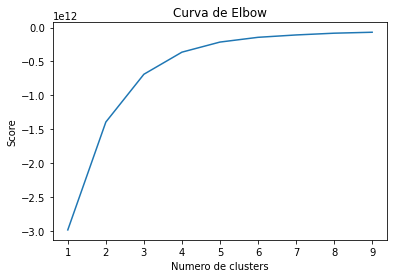

In [370]:
# Presento la curva para elegir el valor K del algoritmo
plt.plot(n_clu,score)
plt.title('Curva de Elbow')
plt.xlabel('Numero de clusters')
plt.ylabel('Score')
plt.show()

##### La curva parece aplanarse en 4, se utilizará ese valor K, operativamente es un grupo interesante para focalizar acciones

In [371]:
# calculamos el algoritmo k_means
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
# printeamos los centroides de los clusters
print(centroids)

[[2.34824262e-03 5.41773448e-03 2.42953404e-02 5.31132286e+03
  7.38120104e+00]
 [2.10000000e-03 4.38750000e-03 3.09375000e-02 2.46853022e+05
  6.37500000e+00]
 [2.65959596e-03 6.51338384e-03 2.83320707e-02 5.61307853e+04
  7.78030303e+00]]


In [372]:
# Calculamos los clusters para todos los datos
labels = kmeans.predict(X)
# etiquetamos los datos con el cluster asignado
clusters=['1','2','3']
asignar=[]
for row in labels:
    asignar.append(clusters[row])
data['kmeans_cluster'] = asignar

In [373]:
data.value_counts('kmeans_cluster')

kmeans_cluster
1    4979
3     396
2      24
dtype: int64

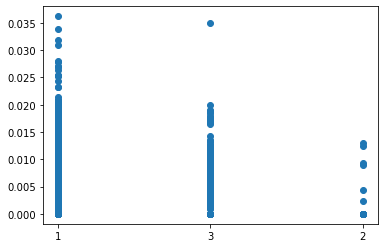

In [374]:
plt.scatter(x=data['kmeans_cluster'],y=data["cancellations_rate"])

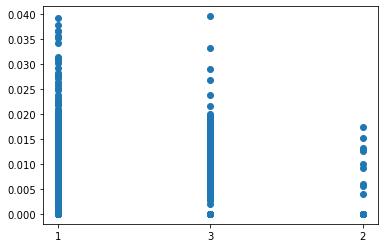

In [375]:
plt.scatter(x=data['kmeans_cluster'],y=data["claims_rate"])

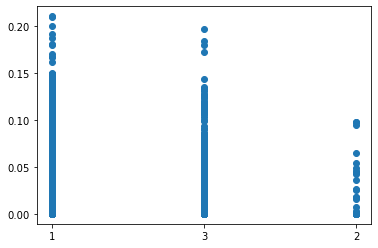

In [376]:
plt.scatter(x=data['kmeans_cluster'],y=data["delayed_handling_time_rate"])

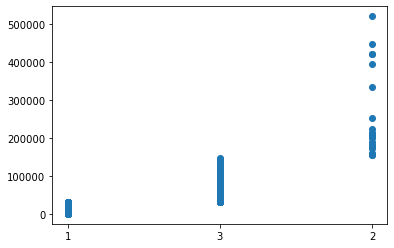

In [377]:
plt.scatter(x=data['kmeans_cluster'],y=data["avg_ticket"])

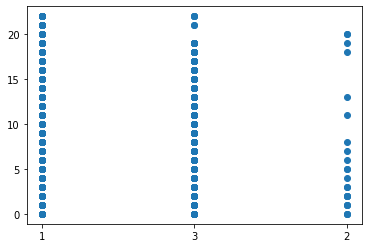

In [378]:
plt.scatter(x=data['kmeans_cluster'],y=data["antiquity_ages"])